**Libraries**

In [1]:
import sqlite3
import pandas as pd
import numpy as np

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

<br>

**Settings**

In [2]:
sns.set(font_scale=1)
az.style.use('arviz-darkgrid')

<br>
<br>

## Reading the Data


### Database connection instance

In [3]:
class SQLITE:

    def __init__(self, databaseuri: str):
        """
        
        :param databaseuri: The URI of a database file
        """
        
        self.databaseuri = databaseuri

    def connecting(self):
        """
        
        :return: database connection instance
        """

        connection = None

        try:
            connection = sqlite3.connect(self.databaseuri)
        except ConnectionError as err:
            raise Exception(err.strerror) in err

        return connection

In [4]:
sqlite = SQLITE(databaseuri='../data/gpinhours.sqlite')

<br>
<br>

### Data reading

In [5]:
connection = sqlite.connecting()
query = 'SELECT * FROM inhours'
inhours = pd.read_sql_query(query, connection)
connection.close()

In [6]:
inhours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47084 entries, 0 to 47083
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CODE        47084 non-null  object 
 1   NAME        47084 non-null  object 
 2   TOTAL_POP   46862 non-null  object 
 3   Flu_OBS     46669 non-null  float64
 4   Vom_OBS     46672 non-null  float64
 5   Diarr_OBS   46672 non-null  float64
 6   Gastro_OBS  46757 non-null  float64
 7   lastdate    47084 non-null  float64
 8   week        47084 non-null  float64
dtypes: float64(6), object(3)
memory usage: 3.2+ MB


<br>
<br>

## Data Cleaning

In [7]:
inhours.head()

,CODE,NAME,TOTAL_POP,Flu_OBS,Vom_OBS,Diarr_OBS,Gastro_OBS,lastdate,week
0,E09000002,Barking and Dagenham,63009,1.0,13.0,9.0,33.0,17741.0,30.0
1,E09000003,Barnet,225813,1.0,40.0,101.0,148.0,17741.0,30.0
2,E09000004,Bexley,46339,1.0,11.0,12.0,24.0,17741.0,30.0
3,E09000005,Brent,178399,1.0,43.0,57.0,97.0,17741.0,30.0
4,E09000006,Bromley,168381,0.0,19.0,43.0,79.0,17741.0,30.0


<br>
<br>

### Fix the population count

<br>

**Create function**

In [8]:
def as_number_or_nan(x):
    return pd.to_numeric(x, errors='coerce')
    

In [9]:
inhours.loc[:, 'POP'] = as_number_or_nan(x = inhours.TOTAL_POP)

In [10]:
inhours.head()

,CODE,NAME,TOTAL_POP,Flu_OBS,Vom_OBS,Diarr_OBS,Gastro_OBS,lastdate,week,POP
0,E09000002,Barking and Dagenham,63009,1.0,13.0,9.0,33.0,17741.0,30.0,63009.0
1,E09000003,Barnet,225813,1.0,40.0,101.0,148.0,17741.0,30.0,225813.0
2,E09000004,Bexley,46339,1.0,11.0,12.0,24.0,17741.0,30.0,46339.0
3,E09000005,Brent,178399,1.0,43.0,57.0,97.0,17741.0,30.0,178399.0
4,E09000006,Bromley,168381,0.0,19.0,43.0,79.0,17741.0,30.0,168381.0


<br>

**Missing values**

In [11]:
inhours.loc[np.isnan(inhours.POP), 'NAME'].value_counts()

Bury                         115
Isle of Wight                 53
Wokingham                     50
Merton                         1
Barking and Dagenham           1
Greenwich                      1
Rochdale                       1
Cheshire West and Chester      1
Lambeth                        1
Herefordshire, County of       1
Bexley                         1
Knowsley                       1
Sutton                         1
Name: NAME, dtype: int64

<br>
<br>

### Fix the date

In [12]:
inhours.loc[:, 'date'] = pd.to_datetime(inhours.lastdate, unit='D', origin='unix')

In [13]:
inhours.date.describe(datetime_is_numeric=True)

count                            47084
mean     2017-01-17 20:39:29.620252928
min                2014-01-05 00:00:00
25%                2015-07-17 06:00:00
50%                2017-01-18 12:00:00
75%                2018-07-23 18:00:00
max                2020-01-26 00:00:00
Name: date, dtype: object

<br>
<br>

### Trim the years

In [14]:
inhours.loc[:, 'year'] = inhours.date.dt.year

In [15]:
inhours.year.value_counts()

2017    7897
2015    7748
2019    7748
2018    7748
2016    7748
2014    7599
2020     596
Name: year, dtype: int64

In [16]:
inhours.shape

(47084, 12)

<br>

Reduce

In [17]:
inhours = inhours.loc[inhours.year != 2020, :]

In [18]:
inhours.year.value_counts()

2017    7897
2015    7748
2019    7748
2018    7748
2016    7748
2014    7599
Name: year, dtype: int64

In [19]:
inhours.shape

(46488, 12)

<br>
<br>

### Drop zero populations

In [20]:
inhours = inhours.loc[inhours.POP != 0, :]

In [21]:
inhours = inhours.loc[~np.isnan(inhours.POP), :]

<br>
<br>

### Final clean data

In [22]:
inhours

,CODE,NAME,TOTAL_POP,Flu_OBS,Vom_OBS,Diarr_OBS,Gastro_OBS,lastdate,week,POP,date,year
0,E09000002,Barking and Dagenham,63009,1.0,13.0,9.0,33.0,17741.0,30.0,63009.0,2018-07-29,2018
1,E09000003,Barnet,225813,1.0,40.0,101.0,148.0,17741.0,30.0,225813.0,2018-07-29,2018
2,E09000004,Bexley,46339,1.0,11.0,12.0,24.0,17741.0,30.0,46339.0,2018-07-29,2018
3,E09000005,Brent,178399,1.0,43.0,57.0,97.0,17741.0,30.0,178399.0,2018-07-29,2018
4,E09000006,Bromley,168381,0.0,19.0,43.0,79.0,17741.0,30.0,168381.0,2018-07-29,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
46483,E06000041,Wokingham,150642,14.0,12.0,22.0,38.0,18258.0,52.0,150642.0,2019-12-28,2019
46484,E10000014,Hampshire,1284063,117.0,120.0,240.0,376.0,18258.0,52.0,1284063.0,2019-12-28,2019
46485,E06000046,Isle of Wight,67289,1.0,1.0,1.0,44.0,18258.0,52.0,67289.0,2019-12-28,2019
46486,E06000044,Portsmouth,183875,1.0,1.0,1.0,48.0,18258.0,52.0,183875.0,2019-12-28,2019


<br>
<br>

## North South Divide


### Read the table

In [23]:
connection = sqlite.connecting()
query = 'SELECT * FROM localauth'
localauth = pd.read_sql_query(query, connection)
connection.close()

In [24]:
localauth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NAME    149 non-null    object
 1   NS      149 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


In [25]:
localauth.head()

,NAME,NS
0,Barking and Dagenham,South
1,Barnet,South
2,Barnsley,North
3,Bath and North East Somerset,South
4,Bedford,South


<br>

### Merge with GP data

In [26]:
inhoursNS = inhours.merge(localauth, how='left', on='NAME')

In [27]:
inhoursNS

,CODE,NAME,TOTAL_POP,Flu_OBS,Vom_OBS,Diarr_OBS,Gastro_OBS,lastdate,week,POP,date,year,NS
0,E09000002,Barking and Dagenham,63009,1.0,13.0,9.0,33.0,17741.0,30.0,63009.0,2018-07-29,2018,South
1,E09000003,Barnet,225813,1.0,40.0,101.0,148.0,17741.0,30.0,225813.0,2018-07-29,2018,South
2,E09000004,Bexley,46339,1.0,11.0,12.0,24.0,17741.0,30.0,46339.0,2018-07-29,2018,South
3,E09000005,Brent,178399,1.0,43.0,57.0,97.0,17741.0,30.0,178399.0,2018-07-29,2018,South
4,E09000006,Bromley,168381,0.0,19.0,43.0,79.0,17741.0,30.0,168381.0,2018-07-29,2018,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45919,E06000041,Wokingham,150642,14.0,12.0,22.0,38.0,18258.0,52.0,150642.0,2019-12-28,2019,South
45920,E10000014,Hampshire,1284063,117.0,120.0,240.0,376.0,18258.0,52.0,1284063.0,2019-12-28,2019,South
45921,E06000046,Isle of Wight,67289,1.0,1.0,1.0,44.0,18258.0,52.0,67289.0,2019-12-28,2019,South
45922,E06000044,Portsmouth,183875,1.0,1.0,1.0,48.0,18258.0,52.0,183875.0,2019-12-28,2019,South


<br>
<br>

### Group and aggregate

In [28]:
fields = ['NS', 'year', 'POP', 'Flu_OBS', 'Vom_OBS', 'Diarr_OBS', 'Gastro_OBS']

In [29]:
# Either
# inhoursNS[fields].groupby(by=['NS', 'year']).agg('sum')

# Or
aggNS = inhoursNS[fields].groupby(by=['NS', 'year']).agg(Total=('POP', sum), 
                                                         Flu_OBS=('Flu_OBS', sum), 
                                                         Vom_OBS=('Vom_OBS', sum), 
                                                         Diarr_OBS=('Diarr_OBS', sum), 
                                                         Gastro_OBS=('Gastro_OBS', sum))
aggNS

Total  Flu_OBS   Vom_OBS  Diarr_OBS  Gastro_OBS
NS    year                                                       
North 2014  719655399.0  31870.0  144469.0   279606.0    524322.0
      2015  812875983.0  44352.0  155056.0   302202.0    555413.0
      2016  852949550.0  48895.0  159742.0   307934.0    569276.0
      2017  737539944.0  30220.0  122787.0   248197.0    462994.0
      2018  607900399.0  46228.0   90951.0   194246.0    365863.0
      2019  614454668.0  31826.0   87114.0   186457.0    357594.0
South 2014  759999787.0  47093.0  141909.0   283547.0    507028.0
      2015  838254817.0  61180.0  147032.0   300360.0    537786.0
      2016  908035557.0  66822.0  156401.0   308993.0    558159.0
      2017  769928672.0  40572.0  117494.0   245726.0    442456.0
      2018  641245125.0  45791.0   84614.0   191328.0    343863.0
      2019  647648492.0  34353.0   79300.0   180489.0    324279.0

<br>
<br>

### Consultation rates

In [30]:
classes = ['Flu_OBS', 'Vom_OBS', 'Diarr_OBS', 'Gastro_OBS']
rates =  100000 * np.true_divide(aggNS[classes], aggNS[['Total']])
aggNS.loc[:, ['Flu_rate', 'Vom_rate', 'Diarr_rate', 'Gastro_rate']] = rates.to_numpy()

In [31]:
aggNS[['Flu_rate', 'Vom_rate', 'Diarr_rate', 'Gastro_rate']]

Flu_rate   Vom_rate  Diarr_rate  Gastro_rate
NS    year                                              
North 2014  4.428508  20.074747   38.852762    72.857370
      2015  5.456183  19.074988   37.176889    68.326905
      2016  5.732461  18.728189   36.102252    66.742048
      2017  4.097405  16.648183   33.652008    62.775447
      2018  7.604535  14.961497   31.953590    60.184695
      2019  5.179552  14.177449   30.345119    58.196970
South 2014  6.196449  18.672242   37.308826    66.714229
      2015  7.298497  17.540251   35.831587    64.155432
      2016  7.358963  17.224105   34.028734    61.468848
      2017  5.269579  15.260375   31.915424    57.467142
      2018  7.140951  13.195266   29.836952    53.624267
      2019  5.304266  12.244296   27.868358    50.070216

<br>
<br>

### Plot the Rates

In [32]:
aggNSTable = aggNS.reset_index()
aggNSTable.head()

,NS,year,Total,Flu_OBS,Vom_OBS,Diarr_OBS,Gastro_OBS,Flu_rate,Vom_rate,Diarr_rate,Gastro_rate
0,North,2014,719655399.0,31870.0,144469.0,279606.0,524322.0,4.428508,20.074747,38.852762,72.857370
1,North,2015,812875983.0,44352.0,155056.0,302202.0,555413.0,5.456183,19.074988,37.176889,68.326905
2,North,2016,852949550.0,48895.0,159742.0,307934.0,569276.0,5.732461,18.728189,36.102252,66.742048
3,North,2017,737539944.0,30220.0,122787.0,248197.0,462994.0,4.097405,16.648183,33.652008,62.775447
4,North,2018,607900399.0,46228.0,90951.0,194246.0,365863.0,7.604535,14.961497,31.953590,60.184695


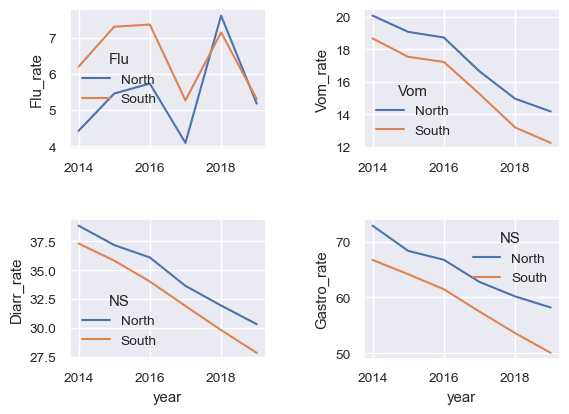

In [33]:
sns.set(font_scale=0.9)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5))

plt.subplots_adjust(left=0.20, bottom=0.2, right=0.9, top=0.9, hspace=0.5, wspace=0.5)

g = sns.lineplot(x='year', y='Flu_rate', hue='NS', data=aggNSTable, ax=axes[0, 0])
g.legend(title='Flu', loc='center left')
g.set_xlabel('')

g = sns.lineplot(x='year', y='Vom_rate', hue='NS', data=aggNSTable, ax=axes[0, 1])
g.legend(title='Vom')
g.set_xlabel('')

sns.lineplot(x='year', y='Diarr_rate', hue='NS', data=aggNSTable, ax=axes[1, 0]);
sns.lineplot(x='year', y='Gastro_rate', hue='NS', data=aggNSTable, ax=axes[1, 1]);


<br>
<br>

## Influenza Data


### Grouping and aggregating

The total populations and total influenza consultations per data

In [36]:
flu = inhours.groupby(by='date').agg(Total=('POP', sum), Flu_OBS=('Flu_OBS', sum))

<br>

### Compute rates

The influenza consultation rate per 100,000

In [40]:
flu.loc[:, 'Flu_rate'] = 100000 * np.true_divide(flu.Flu_OBS, flu.Total)

<br>

Each date's year

In [42]:
flu.loc[:, 'year'] = flu.index.year.values

<br>

Finally

In [43]:
flu

,Total,Flu_OBS,Flu_rate,year
date,,,,
2014-01-05,28607373.0,2264.0,7.914044,2014
2014-01-12,29197811.0,2789.0,9.552086,2014
2014-01-19,29350395.0,2236.0,7.618296,2014
2014-01-26,28766178.0,1990.0,6.917846,2014
2014-02-02,29268260.0,2419.0,8.264926,2014
...,...,...,...,...
2019-12-01,22565354.0,1866.0,8.269314,2019
2019-12-08,23279755.0,2378.0,10.214884,2019
2019-12-15,26375563.0,3687.0,13.978849,2019


<br>
<br>

### Plot National Weekly Rates

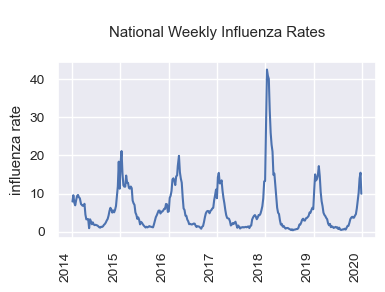

In [69]:
flu.plot(y='Flu_rate', kind='line', figsize=(4.1, 2.6), 
         xlabel='', ylabel='influenza rate', title='\nNational Weekly Influenza Rates\n')
plt.xticks(rotation=90);
plt.legend(labels=['influenza rate']).set_visible(False);

<br>
<br>

## Season Start Detection


### Finding the minimum

<br>

The `when_min` function, which returns the index of the minimum value of a series - the last occurrenece of the minimum value.

In [72]:
def when_min(x: pd.Series):
    return x.where(x==x.min()).last_valid_index()

<br>

Re-ascertaining that the index is sorted in ascending order.

In [75]:
flu.sort_index(inplace = True)

<br>

Hence, the date of each year's minimum value

In [76]:
flu.groupby(by='year').agg(Flu_rate=('Flu_rate', when_min))

,Flu_rate
year,
2014,2014-05-11
2015,2015-07-12
2016,2016-09-04
2017,2017-06-25
2018,2018-07-29
2019,2019-07-28
